In [163]:
import torch
from torch.utils.data import Dataset
import torchaudio
from os.path import join as pjoin
import matplotlib.pyplot as plt
import os
import tqdm
import time
from IPython.display import Audio #listen: ipd.Audio(real.detach().cpu().numpy(), rate=FS)
import numpy as np
import scipy.signal as sig
FS = 48000
import librosa as lsa

# paths
rir_path = '/home/ubuntu/enric/guso_interspeech24/real_rirs.txt'
#rir_path = '/home/ubuntu/Data/DFN/textfiles/singleband_test_rir.txt'
#rir_path = '/home/ubuntu/Data/DFN/textfiles/multiband_test_rir.txt'
#rir_path = '/home/ubuntu/Data/DFN/textfiles/recdirectivity_left_test_rir.txt'
#rir_path = '/home/ubuntu/Data/DFN/textfiles/recsourcedirectivity_left_test_rir.txt'

def plot_tensor(x):
    plt.plot(x.cpu().detach().numpy())


def load_audio(apath):
    audio, fs = torchaudio.load(apath)
    if fs != FS:
        print('resampling')
        resampler = torchaudio.transforms.Resample(fs, FS)
        audio = resampler(audio)    
    if len(audio.shape) > 1:
            audio = audio[0,:]
    return audio


class DFN_dataset(Dataset):
    def __init__(self, rir_path):
        print('Initializing dataset...')

        self.rir_path = rir_path


        # load rir paths
        self.rir_paths = []
        with open(rir_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                self.rir_paths.append(line.rstrip()) 
        print('All paths loaded.')
        
    def __len__(self):
        return len(self.speech_paths)


    def __getitem__(self, idx):
        # handle silent rir
        rir = load_audio(self.rir_paths[idx])
        rir_nrgy = torch.mean(rir**2)
        if rir_nrgy == 0:
            print('silent rir')
            rir = torch.zeros(FS)
            rir[300] = 1.

        rir = rir.numpy()
                  
        return rir
        
        #return speech
real_rirs = DFN_dataset('/home/ubuntu/enric/guso_interspeech24/real_rirs.txt')
fake_rirs = DFN_dataset('/home/ubuntu/Data/DFN/textfiles/recsourcedirectivity_left_test_rir.txt')

Initializing dataset...
All paths loaded.
Initializing dataset...
All paths loaded.


# Option1: librosa onset detection

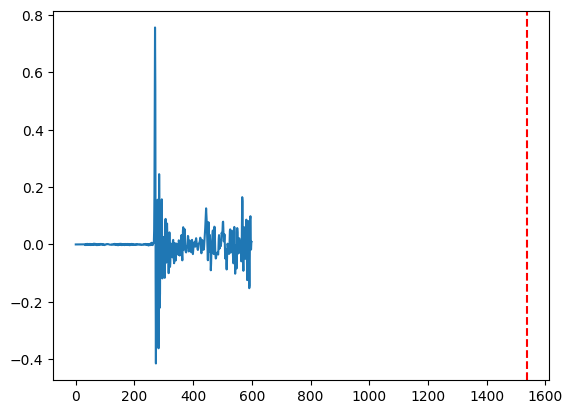

In [22]:
plt.plot(real_rirs[0][0:600])
plt.axvline(x=lsa.onset.onset_detect(y=real_rirs[0], sr=FS, units='samples')[0], color='r', linestyle='--', label='Vertical line at x=5')

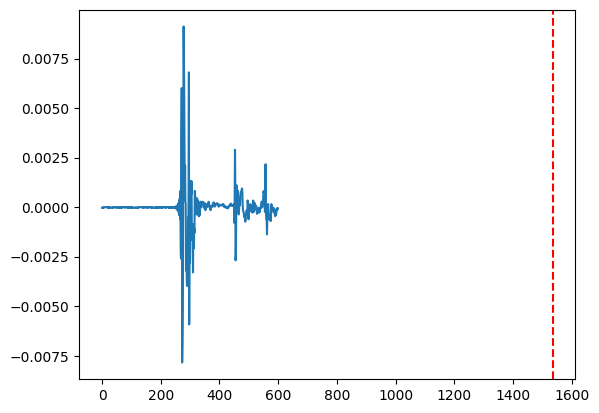

In [20]:
plt.plot(real_rirs[33][0:600])
plt.axvline(x=lsa.onset.onset_detect(y=real_rirs[33], sr=FS, units='samples')[0], color='r', linestyle='--', label='Vertical line at x=5')

# Option2: librosa peak_pick

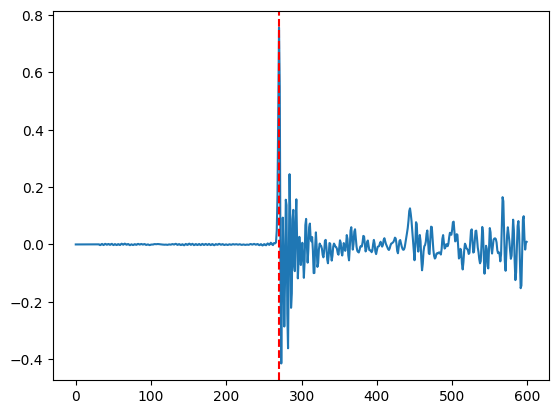

In [30]:
k = 0
plt.plot(real_rirs[k][0:600])
plt.axvline(x=lsa.util.peak_pick(x=real_rirs[k], pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=10)
, color='r', linestyle='--', label='Vertical line at x=5')

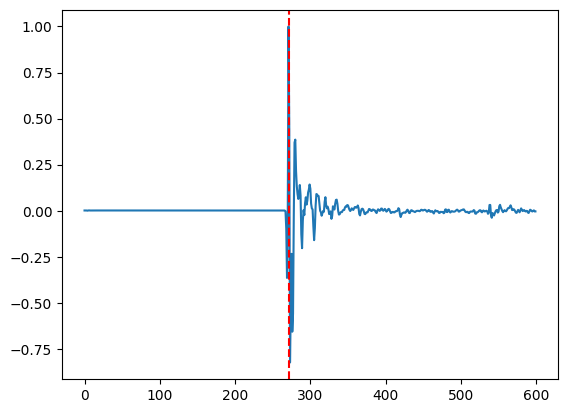

In [57]:
k = 29
plt.plot(real_rirs[k][0:600])
plt.axvline(x=lsa.util.peak_pick(x=real_rirs[k], pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=10)
, color='r', linestyle='--', label='Vertical line at x=5')

In [58]:
k=31
lsa.util.peak_pick(x=real_rirs[k], pre_max=50, post_max=50, pre_avg=3, post_avg=5, delta=1., wait=0)

array([], dtype=float64)

Only works sometimes...

# My approach: based on argmax

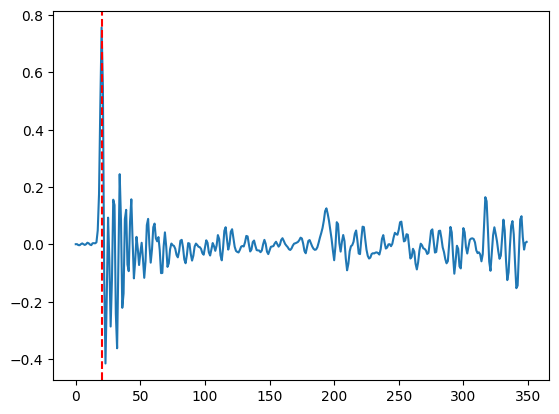

In [67]:
k = 0
plt.plot(real_rirs[k][250:600])
plt.axvline(x=np.argmax(np.abs(real_rirs[k]))-250, color='r', linestyle='--')

Sometimes the maximum is misleading, because some later reflections have more amplitude than the firt one

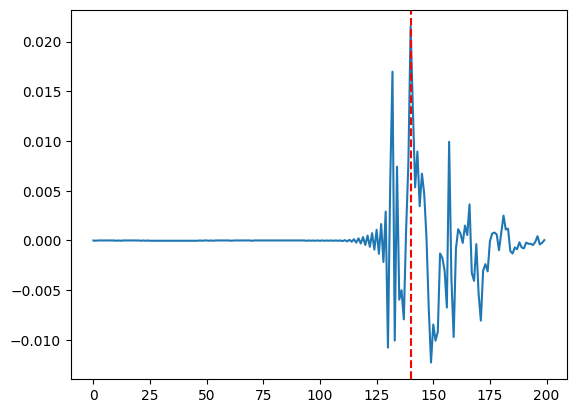

In [100]:
k = 24
plt.plot(real_rirs[k][:200])
plt.axvline(x=np.argmax(np.abs(real_rirs[k])), color='r', linestyle='--')

Let's try to find this "firstarrival" analytically by setting a threshold from the maximum value. In other words: which is the first peak from the left that is at least -6dB from the max?

In [112]:
threshold = 

In [113]:
np.where(np.abs(real_rirs[k]) >= threshold, real_rirs[k])

ValueError: either both or neither of x and y should be given

In [129]:
k = 24
np.where(np.abs(real_rirs[k]) >= 0.5*np.max(np.abs(real_rirs[k])))[0][0]

130

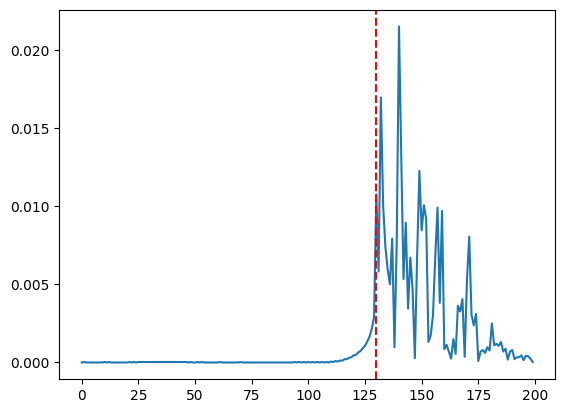

In [133]:
k = 24
plt.plot(np.abs(real_rirs[k][:200]))
plt.axvline(np.where(np.abs(real_rirs[k]) >= 0.5*np.max(np.abs(real_rirs[k])))[0][0], color='r', linestyle='--')

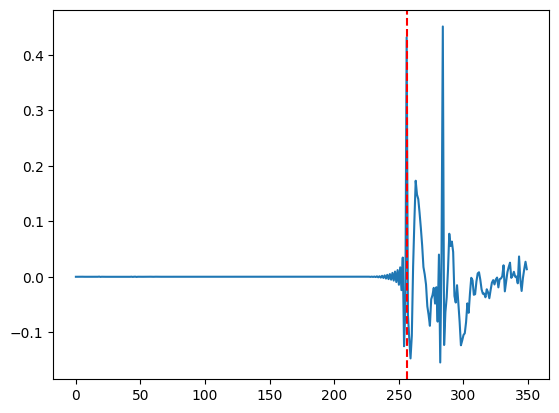

In [141]:
k = 25
plt.plot((real_rirs[k][:350]))
plt.axvline(np.where(np.abs(real_rirs[k]) >= 0.5*np.max(np.abs(real_rirs[k])))[0][0], color='r', linestyle='--')

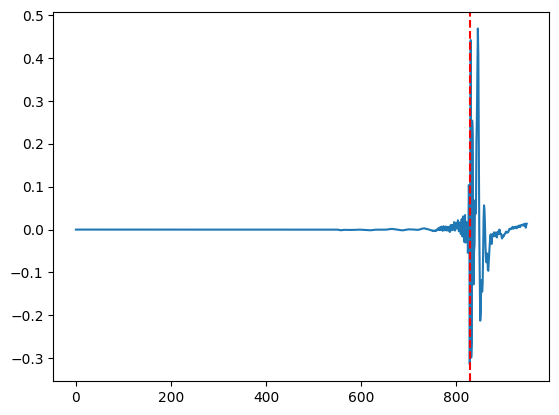

In [165]:
k = 50
plt.plot((fake_rirs[k][:950]))
plt.axvline(np.where(np.abs(fake_rirs[k]) >= 0.5*np.max(np.abs(fake_rirs[k])))[0][0], color='r', linestyle='--')

# solved :)